# 0-Setting

In [1]:
import tensorflow as tf
import numpy as np


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from tensorflow.keras import models, layers, optimizers, losses, metrics, activations

----
# 1. fMNIST 데이터 불러오기

In [14]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255


x_train_noisy = x_train + np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_test_noisy = x_test + np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy = np.clip(x_train_noisy, 0, 1)

x_train.shape, x_test.shape, x_train_noisy.shape, x_test_noisy.shape

((60000, 28, 28), (10000, 28, 28), (60000, 28, 28), (60000, 28, 28))

----
# 2. 모델 Development

## 17.3.1 적층 오토인코더

In [3]:
def build_stacked_ae():
    stacked_encoder = models.Sequential([
        layers.Flatten(input_shape=[28, 28]),
        layers.Dense(100, activation="selu"),
        layers.Dense(10, activation="selu"),
    ])
    stacked_decoder = models.Sequential([
        layers.Dense(100, activation="selu", input_shape=[10]),
        layers.Dense(28 * 28, activation="sigmoid"),
        layers.Reshape([28, 28])
    ])
    stacked_ae = models.Sequential([stacked_encoder, stacked_decoder])
    
    
    return stacked_ae, stacked_encoder


## 17.3.5. 가중치 묶기

In [4]:

class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation = None, **kwargs):
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias", initializer="zeros",
                                      shape=[self.dense.input_shape[-1]])
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)
    
def build_tied_ae():
    dense_1 = tf.keras.layers.Dense(100, activation="selu")
    dense_2 = tf.keras.layers.Dense(30, activation="selu")
    
    tied_encoder = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=[28,28]),
        dense_1,
        dense_2
    ])
    
    tied_decoder = tf.keras.models.Sequential([
        DenseTranspose(dense_2, activation="selu"),
        DenseTranspose(dense_1, activation="sigmoid"),
        tf.keras.layers.Reshape([28, 28])
    ])
    
    tied_ae = tf.keras.models.Sequential([tied_encoder, tied_decoder])
    
    return tied_ae, tied_encoder  



## 17.4 합성곱 오토인코더

In [22]:
def build_conv_ae():
    conv_encoder = models.Sequential([
        layers.Reshape([28,28,1], input_shape=[28,28]),
        layers.Conv2D(16, kernel_size=3, padding="same", activation="selu"),
        layers.MaxPool2D(pool_size=2),
        layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
        layers.MaxPool2D(pool_size=2),
        layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
        layers.MaxPool2D(pool_size=2)
    ])
    
    conv_decoder = models.Sequential([
        layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid",
                                       activation="selu", input_shape=[3,3,64]),
        layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same",
                                       activation="selu"),
        layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same",
                                        activation="sigmoid"),
        layers.Reshape([28,28])
    ])
    
    conv_ae = models.Sequential([conv_encoder, conv_decoder])
    
    
    return conv_ae, conv_encoder 


## 17.5 순환 오토인코더

In [13]:
def build_recurrent_ae():
    recurrent_encoder = models.Sequential([
        layers.LSTM(100, return_sequences=True, input_shape=[None,28]),
        layers.LSTM(30)
    ])
    
    recurrent_decoder = models.Sequential([
        tf.keras.RepeatVector(28, input_shape=[30]),
        layers.LSTM(100, return_sequences=True),
        layers.TimeDistributed(tf.keras.layers.Dense(28, activation="sigmoid"))
    ])
    
    recurrent_ae = models.Sequential([recurrent_encoder, recurrent_decoder])
    
    return recurrent_ae


## 17.6 잡음제거 오토인코더

* Kyuin: build_denoising_ae는 어떻게 해야할지 몰라서 그냥 위에 따로 Noisy image를 만들었다. 이것을 convonlution autoencoder 에 인풋으로 넣을 예정 

In [25]:

def build_denoising_ae():
    denoising_encoder = models.Sequential([
        layers.Reshape([28,28,1], input_shape=[28,28]),
        layers.Conv2D(16, kernel_size=3, padding="same", activation="selu"),
        layers.MaxPool2D(pool_size=2),
        layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
        layers.MaxPool2D(pool_size=2),
        layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
        layers.MaxPool2D(pool_size=2)
    ])
    
    denoising_decoder = models.Sequential([
        layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid",
                                       activation="selu", input_shape=[3,3,64]),
        layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same",
                                       activation="selu"),
        layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same",
                                        activation="sigmoid"),
        layers.Reshape([28,28])
    ])
    
    denoising_ae = models.Sequential([denoising_encoder, denoising_decoder])
    
    return denoising_ae, denoising_encoder


def build_dropout_ae():
    dropout_enocder = models.Sequential([
        layers.Flatten(input_shape=[28,28]),
        layers.Dropout(0.5),
        layers.Dense(100, activation="selu"),
        layers.Dense(30, activation="selu")
    ])
    
    dropout_decoder = models.Sequential([
        layers.Dense(100, activation="selu", input_shape=[30]),
        layers.Dense(28*28, activation="sigmoid"),
        layers.Reshape([28,28])
    ])
    
    dropout_ae = models.Sequential([dropout_enocder, dropout_decoder])
    
    return dropout_ae, dropout_encoder

## 17.7 희소 오토인코더

In [18]:
def build_sparse_ae():
    sparse_l1_encoder = models.Sequential([
        layers.Flatten(input_shape=[28,28]),
        layers.Dense(100, activation="selu"),
        layers.Dense(300, activation="sigmoid"),
        layers.ActivityRegularization(l1=1e-3)
    ])
    
    sparse_l1_decoder = models.Sequential([
        layers.Dense(100, activation="selu", input_shape=[300]),
        layers.Dense(28*28, activation="sigmoid"),
        layers.Reshape([28,28])
    ])
    
    sparse_l1_ae = models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
    
    return sparse_l1_ae, sparse_l1_encoder

----
# 3. 모델 컴파일 & 훈련

In [5]:
def rounded_accuracy(y_true, y_pred):
    return metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

* output이 image니까, model.fit에서 x_train, y_train이 아니라 x_train, x_train이 되는 것

In [27]:
model, encoder = build_denoising_ae()
model.summary()
model.compile(loss="binary_crossentropy",
                optimizer=optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = model.fit(x_train_noisy, x_train, epochs=20,
                      validation_split=0.2)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_12 (Sequential)   (None, 3, 3, 64)          23296     
_________________________________________________________________
sequential_13 (Sequential)   (None, 28, 28)            23233     
Total params: 46,529
Trainable params: 46,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1500/1500 [==============================] - 27s 18ms/step - loss: 0.3415 - rounded_accuracy: 0.8873 - val_loss: 0.3149 - val_rounded_accuracy: 0.9101
Epoch 2/20
1500/1500 [==============================] - 29s 20ms/step - loss: 0.3091 - rounded_accuracy: 0.9148 - val_loss: 0.3058 - val_rounded_accuracy: 0.9194
Epoch 3/20
1500/1500 [==============================] - 27s 18ms/step - loss: 0.3044 - rounded_accuracy: 0.9187 - val_loss: 0.3029 - val_rounded_accuracy: 0.9208
Epoch 4/20
1500/1500 [===

----
# 4. 모델 시각화

## 17.3.2 재구성 시각화

In [28]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images, n_images=8):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        


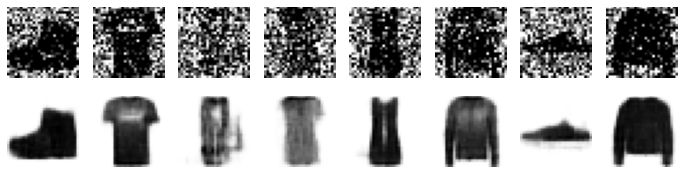

In [29]:
#dropout = layers.Dropout(0.5)
#noise = layers.GaussianNoise(0.2)

show_reconstructions(model, x_test_noisy)

## 17.3.3 패션 MNIST 데이터셋 시각화

In [9]:
from sklearn.manifold import TSNE

def tsne_projection(encoder, x_data):
    x_data_compressed = encoder.predict(x_data)
    tsne = TSNE()
    out_tsne = tsne.fit_transform(x_data_compressed)
    
    return out_tsne

def plot_projection(out_tsne, label):
    x_2d = (out_tsne - out_tsne.min()) / (out_tsne.max() - out_tsne.min())
    plt.figure(figsize=(6,6))
    plt.scatter(x_2d[:, 0], x_2d[:, 1], c=label, s=10, cmap="tab10")
    plt.axis("off")
    plt.show()

def plot_fmnist(out_tsne, x_data, y_data):
    x_2d = (out_tsne - out_tsne.min()) / (out_tsne.max() - out_tsne.min())
    plt.figure(figsize=(10, 8))
    cmap = plt.cm.tab10
    plt.scatter(x_2d[:, 0], x_2d[:, 1], c=y_data, s=10, cmap=cmap)
    image_positions = np.array([[1., 1.]])
    for index, position in enumerate(x_2d):
        dist = np.sum((position - image_positions) ** 2, axis=1)
        if np.min(dist) > 0.02: # if far enough from other images
            image_positions = np.r_[image_positions, [position]]
            imagebox = mpl.offsetbox.AnnotationBbox(
                mpl.offsetbox.OffsetImage(x_data[index], cmap="binary"),
                position, bboxprops={"edgecolor": cmap(y_data[index]), "lw": 2})
            plt.gca().add_artist(imagebox)
    plt.axis("off")
    plt.show()
    

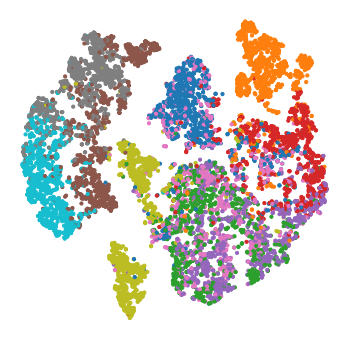

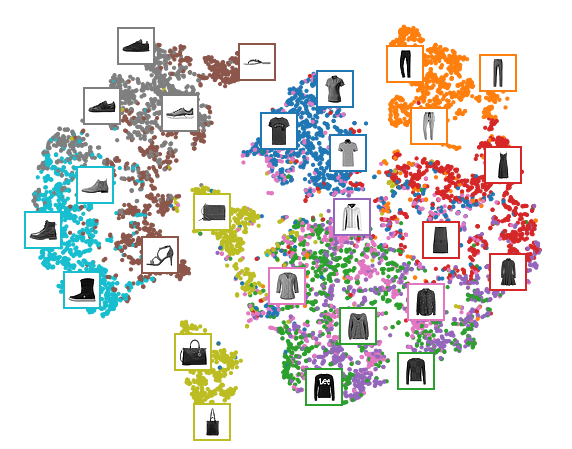

In [10]:
out_tsne = tsne_projection(encoder, x_test)
plot_projection(out_tsne, y_test)
plot_fmnist(out_tsne, x_test, y_test)

----
# 5. 뉴런 활성화 시각화

In [139]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)
    
    
def plot_activations_histogram(encoder, x_data, height=1, n_bins=10):
    x_codings = encoder(x_data).numpy()
    activation_means = x_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    
    plot_percent_hist(ax1, x_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

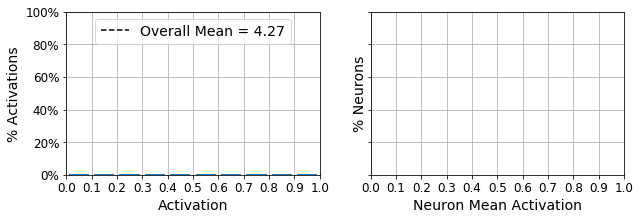

In [141]:
plot_activations_histogram(encoder, x_test, )
plt.show()